In [1008]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from scipy.sparse import rand

# Implementing the screening rule

In [1009]:
def compute_prox(x, mu):
    p = np.zeros(x.size)
    for i in range(x.size):
        if np.abs(x[i]) > mu:
            p[i] = (1 - mu / np.abs(x[i])) * x[i]
    return p

def compute_prox_subgradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 1
        elif np.abs(u[i]) < mu:
            g[i] = 0
        else:
            g[i] = np.random.rand(1)[0]
    return g

def compute_loss_gradient(u, mu):
    g = np.zeros(u.size)
    for i in range(u.size):
        if np.abs(u[i]) > mu:
            g[i] = 2 * (u[i] - np.sign(u[i]) * mu)
    return g

def compute_l1_subgradient(u):
    g = np.zeros(u.size)
    for i in range(u.size):
        if u[i] != 0:
            g[i] = np.sign(u[i])
        else:
            g[i] = 2 * np.random.rand(1)[0] - 1
    return g

def compute_subgradient_old(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_prox_subgradient(output, mu)
    g_1 = np.transpose(D).dot(np.diag(g_1))
    g_1 = g_1.dot(compute_prox(output, mu))
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def compute_subgradient(x, D, y, lmbda, mu):
    output = D.dot(x) - y
    g_1 = compute_loss_gradient(output, mu)
    g_1 = np.transpose(D).dot(g_1)
    g_2 = compute_l1_subgradient(x)
    g = g_1 + lmbda * g_2
    return g

def update_ellipsoid(z, A, g):
    p = z.size
    A_g = A.dot(g)
    den = np.sqrt(g.dot(A_g))
    g = (1 / den) * g
    A_g = A.dot(g)
    z = z - (1 / (p + 1)) * A_g
    A = (p ** 2 / (p ** 2 - 1)) * (A - (2 / (p + 1)) * np.outer(A_g, A_g))
    return z, A

def iterate_ellipsoids(D, y, z_init, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        z, A = update_ellipsoid(z, A, g)
        k += 1 
    return z, A

def iterate_ellipsoids_accelerated(D, y, z_init, s, A_init, lmbda, mu, n_steps=100):
    k = 0
    z = z_init
    A = A_init
    D = np.identity(z.size)
    while k < n_steps:
        g = compute_subgradient(z, D, y, lmbda, mu)
        A_g = A.dot(g)
        den = np.sqrt(g.dot(A_g))
        g = (1 / den) * g
        A_g = A.dot(g)
        z = z - (1 / (p + 1)) * A_g
        s *= p ** 2 / (p ** 2 - 1)
        A_g = A_g.reshape(1,-1)
        L = np.concatenate((L, A_g.T), axis=1)
        D = * D
        k += 1
        
    A = s * np.identity(z.size) - L.dot(D.dot(np.transpose(L)))
    return z, A

def compute_test(D_i, y_i, z, A):
    test = D_i.dot(z) + np.sqrt( (D_i.dot(A.dot(D_i)))) - y_i
    return test

def compute_test_with_linear_ineq(D_i, y_i, z, A, g):
    nu = g.dot(A.dot(D_i)) / g.dot(A.dot(g))
    if nu < 0:
        test = compute_test(D_i, y_i, z, A)
    else:
        new_D_i = D_i - nu * g
        mu = np.sqrt(new_D_i.dot(A.dot(new_D_i))) / 2
        body = D_i.dot(A.dot(new_D_i)) / (2 * mu)
        test = D_i.dot(z) + body - y_i
    return test

def test_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    results = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        #print(test_1, test_2)
        if test_1 < mu and test_2 < mu:
            results[i] = 1
    return results

def rank_dataset(D, y, z, A, lmbda, mu, linear_ineq=True):
    scores = np.zeros(D.shape[0])
    g = compute_subgradient(z, D, y, lmbda, mu)
    for i in range(D.shape[0]):
        if linear_ineq:
            test_1 = compute_test_with_linear_ineq(D[i], y[i], z, A, g)
            test_2 = compute_test_with_linear_ineq(-D[i], -y[i], z, A, g)
        else:
            test_1 = compute_test(D[i], y[i], z, A)
            test_2 = compute_test(-D[i], -y[i], z, A)
        #print(test_1, test_2)
        scores[i] = np.maximum(test_1, test_2)
    return scores

### Tools to screen and fit models

In [1010]:
from sklearn.linear_model import Lasso

def find_best_lasso(X, y):
    alpha = {'alpha':[0.001,0.01,0.1,1,10]}
    clf = sklearn.model_selection.GridSearchCV(estimator = Lasso(), param_grid = alpha)
    clf.fit(X,y)
    best_lasso = clf.best_estimator_
    return best_lasso, clf.best_score_

In [1011]:
from random import randint

def random_screening(X, y, nb_points_to_keep):
    X_screened = X
    y_screened = y
    while X_screened.shape[0] > nb_points_to_keep:
        i = randint(0,X_screened.shape[0]-1)
        X_screened = np.delete(X_screened, i, 0)
        y_screened = np.delete(y_screened, i, 0)
    return X_screened, y_screened

# Generating the data

In [1012]:
#import data, real and synthetic

def make_data(param_set, noise=True):

    n = param_set[0]
    p = param_set[1]
    sparsity = param_set[2]
    X = np.zeros((n,p))
    y = np.zeros(n)
    true_params = rand(p, 1, density = sparsity).A.ravel()
    #print(np.linalg.norm(true_params, ord=1))
    sparse_ones = np.zeros(p)
    for i in range(p):
        if true_params[i] != 0:
            sparse_ones[i] = 1
    true_params = 2 * true_params - sparse_ones

    noise_norm = 0

    for i in range(n):
        # sample x in [-1,1]^p box
        x = 2 * np.random.rand(p) - np.ones(p) 
        X[i,:] = x
        y[i] = np.dot(true_params,x)
        if noise:
            w = np.random.randn(1) / 10
            y[i] += w
            noise_norm += (np.linalg.norm(w)) ** 2

    return X, y, true_params, np.sqrt(noise_norm)

param_set = (100, 10, 0.2)
X, y, true_params, _ = make_data(param_set)

# Testing the screening rule

## Synthetic dataset

In [1013]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D 

# we generate the dataset, find the set X for x and execute the test.
param_set = (100, 2, 1/2)
X, y, true_params, noise_norm = make_data(param_set)
z_init = np.zeros(2)
A_init = 2 * np.identity(2) #TODO: find rule for the radius

In [1014]:
lmbda = 0.1 * np.sqrt(np.log(2)) * noise_norm #0.001 #TODO: find rule for lmbda
print(lmbda)
mu = 0.15 #TODO: evaluate sensitivity in mu
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)

0.0930516550544


[ 1.  1.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.] 82


<IPython.core.display.Javascript object>


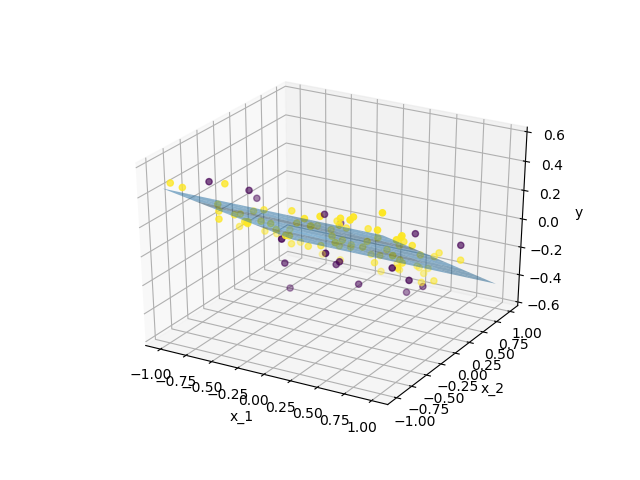

In [1015]:
results = test_dataset(X, y, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=results)

# we plot the plane from which the datapoints are generated
x_1_true = np.linspace(-1,1,10)
x_2_true = np.linspace(-1,1,10)
X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
y_real = true_params[0] * X_1_true + true_params[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_real, alpha=0.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

The more we regularize, the lower the coefficient must be : the real model cannot be recovered and the screened points describe the plane that would be recovered using a Lasso with such lambda (to be verified). This probably explains why less datapoints are screened : since the solution that will be recovered by the Lasso with such lambda is less close to the ground truth, more points are going to pass the test (i.e prediction far from the ground truth) and not be discarded!

In [1016]:
X_screened = []
y_screened = []
for i in range(X.shape[0]):
    if results[i] == 0:
        X_screened.append(X[i,:])
        y_screened.append(y[i])
X_screened = np.asarray(X_screened)
y_screened = np.asarray(y_screened)

X_r, y_r = random_screening(X, y, X_screened.shape[0])
print(X.shape, X_screened.shape, X_r.shape)

lasso, _ = find_best_lasso(X,y)
lasso_screened, _ = find_best_lasso(X_screened, y_screened)
lasso_r, _ = find_best_lasso(X_r, y_r)
print(lasso.score(X,y), lasso_screened.score(X,y), lasso_r.score(X,y))
print(lasso, lasso_screened, lasso_r)

(100, 2) (18, 2) (18, 2)
0.829413655231 0.720294789109 0.821062914235
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


Let us plot the result.

<IPython.core.display.Javascript object>


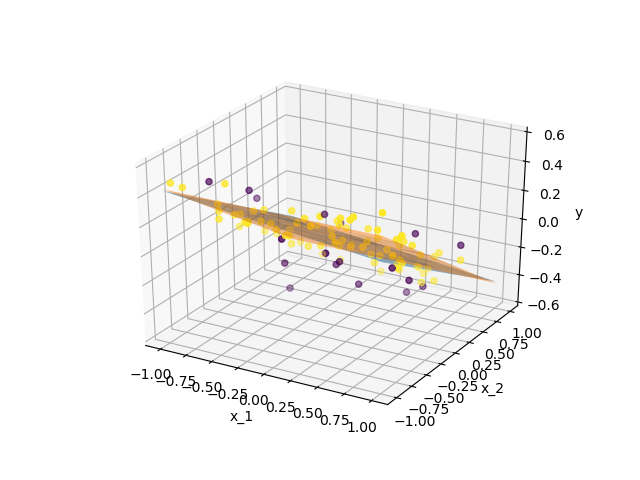

In [1017]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], y, c=results)

# we plot the plane from which the datapoints are generated
x_1_true = np.linspace(-1,1,10)
x_2_true = np.linspace(-1,1,10)
X_1_true, X_2_true = np.meshgrid(x_1_true, x_2_true)
y_screened = lasso_screened.coef_[0] * X_1_true + lasso_screened.coef_[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_screened, alpha=0.5)
y_regular = lasso.coef_[0] * X_1_true + lasso.coef_[1] * X_2_true
ax.plot_surface(X_1_true, X_2_true, y_regular, alpha=0.5)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
plt.show()

## Synthetic dataset with n < p

In [1018]:
param_set = (100, 500, 10 / 500)
X, y, true_params, noise_norm = make_data(param_set)
z_init = np.zeros(500)
A_init = np.sqrt(500) * np.identity(500)
lmbda =  np.sqrt(np.log(500)) * noise_norm
print('Theoretical lmbda:', lmbda)
mu = 62 #TODO: how to set mu ?
z, A = iterate_ellipsoids(X, y, z_init, A_init, lmbda, mu)
results = test_dataset(X, y, z, A, lmbda, mu, linear_ineq=True)
print(results, np.count_nonzero(results))

Theoretical lmbda: 2.22285715156
[ 1.  1.  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  1.  0.  0.
  0.  1.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.
  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.] 46


In [1019]:
X_screened = []
y_screened = []
for i in range(X.shape[0]):
    if results[i] == 0:
        X_screened.append(X[i,:])
        y_screened.append(y[i])
X_screened = np.asarray(X_screened)
y_screened = np.asarray(y_screened)

X_r, y_r = random_screening(X, y, X_screened.shape[0])
print(X.shape, X_screened.shape, X_r.shape)

lasso_regular, _ = find_best_lasso(X,y)
lasso_screened, _ = find_best_lasso(X_screened, y_screened)
lasso_r, _ = find_best_lasso(X_r, y_r)

print(lmbda)

#lasso_regular = Lasso(alpha=lmbda)
#lasso_regular.fit(X, y)
#lasso_screened = Lasso(alpha=lmbda)
#lasso_screened.fit(X_screened, y_screened)
#lasso_r = Lasso(alpha=lmbda)
#lasso_r.fit(X_r, y_r)

print(lasso_regular.score(X,y), lasso_screened.score(X,y), lasso_r.score(X,y))
print(lasso_regular, lasso_screened, lasso_r)

(100, 500) (54, 500) (54, 500)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

2.22285715156
0.996413532539 0.994497589149 0.872752693452
Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False) Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Now let us compare the solutions of those Lassos to the ground truth. Now, let us change the scale and do multiple experiments 10x times.

In [1032]:
def screen(X, y, scores, nb_to_delete):
    X_screened = X
    y_screened = y
    compt = 0
    idx_to_delete = np.argsort(scores)[0:nb_to_delete]
    X_screened = np.delete(X, idx_to_delete, 0)
    y_screened = np.delete(y, idx_to_delete, 0)
    return X_screened, y_screened

def experiment(nb_datapoints, nb_to_delete, dimension, sparsity):
    
    print('More points in the dataset than the theoretical limit :', 
          nb_datapoints > np.log(dimension) * sparsity,
         'More points in the screened dataset than the theoretica limit :',
          nb_datapoints - nb_to_delete > np.log(dimension) * sparsity)
    
    compt = 0
    score_regular = 0
    score_screened = 0
    score_r = 0
    dist_regular = 0
    dist_r = 0
    dist_screened = 0
    while compt<10:
        compt += 1
        X, y, true_params, noise_norm = make_data([2 * nb_datapoints, dimension, sparsity / dimension])
        X_train = X[0:nb_datapoints]
        X_test = X[nb_datapoints:]
        y_train = y[0:nb_datapoints]
        y_test = y[nb_datapoints:]
        z_init = np.zeros(dimension)
        A_init = np.sqrt(dimension) * np.identity(dimension)
        lmbda =  np.sqrt(np.log(dimension)) * noise_norm
        mu = 1 # mu seems not to have any effect on the scores.
        z, A = iterate_ellipsoids(X_train, y_train, z_init, A_init, lmbda, mu)
        scores = rank_dataset(X_train, y_train, z, A, lmbda, mu, linear_ineq=True)
        X_screened, y_screened = screen(X_train, y_train, scores, nb_to_delete)
        X_r, y_r = random_screening(X_train, y_train, X_screened.shape[0])
        
        lasso_regular, _ = find_best_lasso(X_train,y_train)
        lasso_screened, _ = find_best_lasso(X_screened, y_screened)
        lasso_r, _ = find_best_lasso(X_r, y_r)
        
        score_regular += lasso_regular.score(X_test, y_test)
        score_screened += lasso_screened.score(X_test, y_test)
        score_r += lasso_r.score(X_test, y_test)
        dist_regular += np.linalg.norm(true_params - lasso_regular.coef_)
        dist_screened += np.linalg.norm(true_params - lasso_screened.coef_)
        dist_r += np.linalg.norm(true_params - lasso_r.coef_)
        
    #print('Score regular:', score_regular / 10 , 'Score screened:', score_screened / 10,
    #      'Score random:', score_r / 10)
    #print('Distance regular:', dist_regular / 10, 'Distance screened:', dist_screened / 10,
    #      'Distance random:', dist_r / 10 )
    
    return score_regular / 10, score_screened / 10, score_r / 10

Ecrire une fonction pour générer une expérience qui vérifie les hypothèses de Lasso. Important: on base le screening sur le lambda qui serait utilisé pour le Lasso global. Ensuite, on fitte un Lasso sur le dataset restant et lambda est alors cross-validé. Plot score = f(points enlevés ?)

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True
More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True
More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True
More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True
More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True
More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : True


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

More points in the dataset than the theoretical limit : True More points in the screened dataset than the theoretica limit : False


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

<IPython.core.display.Javascript object>


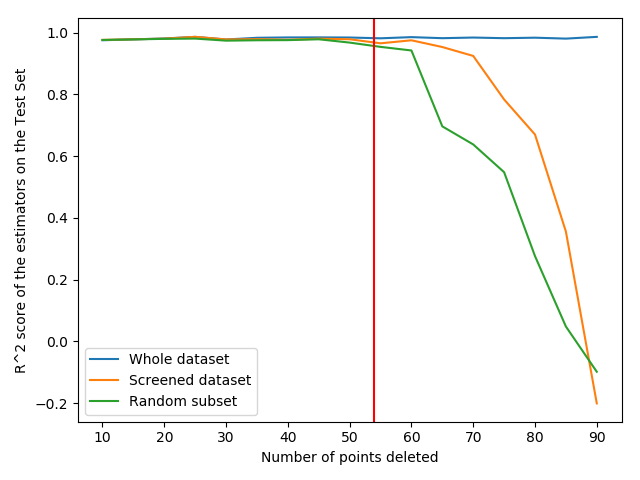

In [1041]:
scores_regular = []
scores_screened = []
scores_r= []

nb_to_del_table = [10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90]

for i in nb_to_del_table:
    score_regular, score_screened, score_r = experiment(100, i, 100, 10)
    scores_regular.append(score_regular)
    scores_screened.append(score_screened)
    scores_r.append(score_r)

fig, ax1 = plt.subplots()
ax1.plot(nb_to_del_table, scores_regular, label='Whole dataset')
ax1.plot(nb_to_del_table, scores_screened, label='Screened dataset')
ax1.plot(nb_to_del_table, scores_r, label='Random subset')
ax1.set_xlabel('Number of points deleted')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('R^2 score of the estimators on the Test Set')
ax1.tick_params('y')
plt.axvline(x= 100 - 10 * np.log(100), color='red')
fig.tight_layout()
ax1.legend()
plt.show()

In [1040]:
10 * np.log(100)

46.051701859880922

## Real dataset

### n < p

In [ ]:
import pandas as pd 

regular_path = '/nas/home2/g/gmialon/research/datasets/leukemia_big.csv'
laptop_path = '/Users/gregoire/Desktop/research/datasets/leukemia_big.csv'
l_data = pd.read_csv(regular_path)

def create_X_y(data):
    
    X = np.transpose(data.values)
    y_ = data.columns.values
    y = np.ones(len(y_))
    for i in range(len(y_)):
        if 'AML' in y_[i]:
            y[i] = -1
    return X, y

def scoring(estimator, X, y):
    
    score = 0
    
    for i in range(len(y)):
        if estimator.predict(X[i].reshape(1, -1))* y[i] > 0:
            score += 1

    return score / len(y)

X, y = create_X_y(l_data)
          
def experiment_real(X, y, nb_to_delete, lmbda, nb_test=10):
    
    score_regular = 0
    score_screened = 0
    score_r = 0
    compt = 0
    
    while compt < nb_test:
        compt += 1
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                            random_state=compt)
        z_init = np.zeros(X_train.shape[1])
        A_init = np.sqrt(X_train.shape[1]) * np.identity(X_train.shape[1])
        #lmbda =  0.1 * np.sqrt(np.log(X_train.shape[1])) # is it ok ?
        mu = 1 # mu seems not to have any effect on the scores.
        z, A = iterate_ellipsoids(X_train, y_train, z_init, A_init, lmbda, mu, n_steps = 100)
        scores = rank_dataset(X_train, y_train, z, A, lmbda, mu, linear_ineq=True)
        X_screened, y_screened = screen(X_train, y_train, scores, nb_to_delete)
        X_r, y_r = random_screening(X_train, y_train, X_train.shape[0] - nb_to_delete)
        
        lasso_regular, _ = find_best_lasso(X_train,y_train)
        lasso_screened, _ = find_best_lasso(X_screened, y_screened)
        lasso_r, _ = find_best_lasso(X_r, y_r)
        
        score_regular += scoring(lasso_regular, X_test, y_test)
        score_screened += scoring(lasso_screened, X_test, y_test)
        score_r += scoring(lasso_r, X_test, y_test)
        
        print(X_train.shape, X_screened.shape, X_r.shape)
    
    return score_regular / nb_test, score_screened / nb_test, score_r / nb_test

#experiment_real(X, y, 10, 5)


nb_to_del_table = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

lmbda_table = [0.0001, 0.001, 0.01, 0.1, 1.0, 10]

for lmbda in lmbda_table:
    
    scores_regular = []
    scores_screened = []
    scores_r= []
    
    for i in nb_to_del_table:
        score_regular, score_screened, score_r = experiment_real(X, y, i, lmbda)
        scores_regular.append(score_regular)
        scores_screened.append(score_screened)
        scores_r.append(score_r)

    fig, ax1 = plt.subplots()
    ax1.plot(nb_to_del_table, scores_regular, label='Whole dataset')
    ax1.plot(nb_to_del_table, scores_screened, label='Screened dataset')
    ax1.plot(nb_to_del_table, scores_r, label='Random subset')
    ax1.set_xlabel('Number of points deleted, lambda = ' + str(lmbda))
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Accuracy of the estimators on the Test Set')
    ax1.tick_params('y')
    #plt.axvline(x= 100 - 10 * np.log(100), color='red')
    fig.tight_layout()
    ax1.legend()
    plt.show()

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (12, 7128) (12, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (7, 7128) (7, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


<IPython.core.display.Javascript object>

/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (52, 7128) (52, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (47, 7128) (47, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (42, 7128) (42, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (37, 7128) (37, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (32, 7128) (32, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (27, 7128) (27, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (22, 7128) (22, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/ROCQ/sierra/gmialon/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_desc

(57, 7128) (17, 7128) (17, 7128)


Question:
- Sensibilité à l'initialisation, au nombre de steps d'ellipsoides, à mu.
- Quand tout cela varie, les points éliminés le sont-ils de façon consistante => plutôt oui
- Peut-on fitter des modèles sur les points non-screenés et maintenir un bon niveau de performance? (par-rapport à une élimination random)

Y-a-t-il un scaling à faire pour Dx - y ?
Intercept ?
Essayer d'initialiser à un point proche de la solution


TODO LIST

- Expérience avec meilleure initialisation.
- Screening de features avant?
- Print test value. Quelle est leur distribution ? => semble ne pas dépendre de n_steps